In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import dgl
from scipy.spatial import cKDTree

from equivariant_attention.modules import GSE3Res, GNormSE3, GConvSE3, get_basis_and_r
from equivariant_attention.fibers import Fiber

/home/jeongbinpark/miniconda3/envs/se3_visium/lib/python3.8/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import math

from pathlib import Path, PurePath
from typing import Union, Dict, Optional, Tuple, BinaryIO
import json

def to_spatial(adata, path, library_id = 'TNBC1'):
    
    adata.uns["spatial"][library_id] = dict()
    path = Path(path)
    
    files = dict(
        tissue_positions_file=path / 'spatial/tissue_positions_list.csv',
        scalefactors_json_file=path /  'spatial/scalefactors_json.json',
        hires_image=path / 'spatial/tissue_hires_image.png',
        lowres_image=path / 'spatial/tissue_lowres_image.png',
    )

    # check if files exists, continue if images are missing
    for f in files.values():
        if not f.exists():
            if any(x in str(f) for x in ["hires_image", "lowres_image"]):
                logg.warning(
                    f"You seem to be missing an image file.\n"
                    f"Could not find '{f}'."
                )
            else:
                raise OSError(f"Could not find '{f}'")

    adata.uns["spatial"][library_id]['images'] = dict()
    for res in ['hires', 'lowres']:
        try:
            adata.uns["spatial"][library_id]['images'][res] = imread(
                str(files[f'{res}_image'])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")

    # read json scalefactors
    adata.uns["spatial"][library_id]['scalefactors'] = json.loads(
        files['scalefactors_json_file'].read_bytes()
    )

    #adata.uns["spatial"][library_id]["metadata"] = {
    #    k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
    #    for k in ("chemistry_description", "software_version")
    #    if k in attrs
    #}

    # read coordinates
    positions = pd.read_csv(files['tissue_positions_file'], header=None)
    positions.columns = [
        'barcode',
        'in_tissue',
        'array_row',
        'array_col',
        'pxl_col_in_fullres',
        'pxl_row_in_fullres',
    ]
    positions.index = positions['barcode']

    adata.obs = adata.obs.join(positions, how="left")
    
    adata.obsm['spatial'] = adata.obs[
        ['pxl_row_in_fullres', 'pxl_col_in_fullres']
    ].to_numpy()
    
    adata.obs.drop(
        columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
        inplace=True,
    )

    return adata

def load_adata(tissue_dir):
    adata1 = sc.read_mtx(tissue_dir + 'matrix.mtx') 
    adata1 = adata1.transpose() 
    cellname = pd.read_csv(tissue_dir + 'barcodes.tsv', sep="\t", header=None, index_col=1, names=['idx', 'barcode']) 
    cellname.index = cellname['idx']
    featurename = pd.read_csv(tissue_dir + 'features.tsv', sep='\t', header=None, index_col=1, names=['gene_ids', 'feature_types'])
    adata1.var = featurename
    adata1.obs = cellname
    adata1.uns["spatial"] = dict()
    adata1 = to_spatial(adata1, tissue_dir, library_id='Library_1')
    adata1 = adata1[adata1.obs.in_tissue == 1,:]
    adata1.var_names_make_unique()
    adata1.obs['unnormalized_counts'] = adata1.X.sum(axis=1).A1
    sc.pp.normalize_total(adata1, inplace=True)
    adata1.obs['normalized_counts'] = adata1.X.sum(axis=1).A1
    sc.pp.log1p(adata1)
    sc.pp.highly_variable_genes(adata1, flavor="seurat", n_top_genes=2000)

    return adata1

In [3]:
adata_24_1 = load_adata("t_24h_m1/")
adata_24_2 = load_adata("t_24h_m2/")
adata_48_1 = load_adata("t_48h_m4/")
adata_48_2 = load_adata("t_48h_m5/")
adata_72_1 = load_adata("t_72h_m1/")
adata_72_2 = load_adata("t_72h_m2/")

In [4]:
def subset_adata_by_grid(adata, r, c, n_bins=4):
    assert 1 <= r <= n_bins and 1 <= c <= n_bins, "r과 c는 1부터 n_bins 사이의 정수여야 합니다."

    # row와 col 값
    row_vals = adata.obs['array_row'].to_numpy()
    col_vals = adata.obs['array_col'].to_numpy()

    # row와 col 각각을 10등분한 경계값
    row_bins = np.quantile(row_vals, q=np.linspace(0, 1, n_bins + 1))
    col_bins = np.quantile(col_vals, q=np.linspace(0, 1, n_bins + 1))

    # 해당 구간에 해당하는 조건
    row_mask = (row_vals >= row_bins[r - 1]) & (row_vals <= row_bins[r])
    col_mask = (col_vals >= col_bins[c - 1]) & (col_vals <= col_bins[c])

    # 둘 다 만족하는 셀만 필터링
    selected_mask = row_mask & col_mask
    adata_subset = adata[selected_mask].copy()

    return adata_subset

In [5]:
# -----------------------------
# 1) Utilities
# -----------------------------
def set_seed(seed=0):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def preprocess_for_model(adata, pca_dim=64, n_neighbors=15, n_pcs=30):
    adata = adata.copy()
    # assumes: load_adata already did normalize/log1p/HVG flags
    adata = adata[:, adata.var["highly_variable"]].copy()
    import scanpy as sc
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=min(n_pcs, adata.obsm["X_pca"].shape[1]))
    return adata

def spatial_knn_csr(coords_xy, k=6, self_loop=False):
    n = coords_xy.shape[0]
    tree = cKDTree(coords_xy)
    # k+1 because first neighbor is itself (distance 0)
    dists, idxs = tree.query(coords_xy, k=min(k+1, n))
    rows, cols = [], []
    for i in range(n):
        neigh = idxs[i]
        for j in neigh:
            if (not self_loop) and (j == i):
                continue
            rows.append(i); cols.append(int(j))
    data = np.ones(len(rows), dtype=np.float32)
    csr = sp.csr_matrix((data, (rows, cols)), shape=(n, n))
    csr.eliminate_zeros()
    return csr

def dgl_from_edges_and_x(src, dst, x3, add_self_loop=True, device="cpu"):
    g = dgl.graph((src, dst), num_nodes=x3.shape[0])
    g = dgl.to_simple(g)

    if add_self_loop:
        g = dgl.remove_self_loop(g)
        g = dgl.add_self_loop(g)

    g = g.to(device)

    x = torch.from_numpy(x3.astype(np.float32)).to(device)
    g.ndata["x"] = x

    src_t, dst_t = g.edges()
    d = x[dst_t] - x[src_t]
    g.edata["d"] = d
    return g

def dgl_from_connectivities(connectivities, x3, add_self_loop=True, device="cpu"):
    coo = connectivities.tocoo()
    src = coo.row.astype(np.int64)
    dst = coo.col.astype(np.int64)
    return dgl_from_edges_and_x(src, dst, x3, add_self_loop=add_self_loop, device=device)

def rotate_xy(coords_xy, angle_rad):
    c = np.cos(angle_rad); s = np.sin(angle_rad)
    R = np.array([[c, -s],[s, c]], dtype=np.float32)
    return coords_xy @ R.T

In [6]:
# -----------------------------
# 2) SE(3) Encoder + Decoder (self-supervised reconstruction)
# -----------------------------
class SE3VisiumEncoder(torch.nn.Module):
    def __init__(self, in_dim, num_layers=4, num_degrees=4, num_channels=32, div=4, n_heads=4):
        super().__init__()
        self.num_degrees = num_degrees

        fibers_in = Fiber(1, in_dim)                 # type-0 input with in_dim channels
        fibers_mid = Fiber(num_degrees, num_channels)
        fibers_out = Fiber(1, num_channels * num_degrees)  # output only type-0 (invariant) embedding

        blocks = []
        fin = fibers_in
        for _ in range(num_layers):
            blocks.append(GSE3Res(fin, fibers_mid, edge_dim=0, div=div, n_heads=n_heads))
            blocks.append(GNormSE3(fibers_mid))
            fin = fibers_mid
        blocks.append(GConvSE3(fibers_mid, fibers_out, self_interaction=True, edge_dim=0))

        self.blocks = torch.nn.ModuleList(blocks)

    def forward(self, G):
        basis, r = get_basis_and_r(G, self.num_degrees - 1)
        h = {"0": G.ndata["f"]}  # type-0 input
        for layer in self.blocks:
            h = layer(h, G=G, r=r, basis=basis)
        # h["0"]: [N, C, 1]
        return h["0"].squeeze(-1)  # [N, C]

class SE3ReconstructionModel(torch.nn.Module):
    def __init__(self, in_dim, emb_dim, num_layers=4, num_degrees=4, num_channels=32, div=4, n_heads=4):
        super().__init__()
        self.enc = SE3VisiumEncoder(
            in_dim=in_dim,
            num_layers=num_layers,
            num_degrees=num_degrees,
            num_channels=num_channels,
            div=div,
            n_heads=n_heads
        )
        self.dec = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, in_dim)
        )

    def forward(self, G):
        z = self.enc(G)          # [N, emb_dim]
        xhat = self.dec(z)       # [N, in_dim]
        return z, xhat

In [7]:
# -----------------------------
# 3) C6/Hexatic score (psi6 magnitude) and "symmetry breaking" (rotation sensitivity)
# -----------------------------
def compute_psi6_mag(coords_xy, nbr_csr, w_csr=None):
    n = coords_xy.shape[0]
    x = coords_xy[:, 0]
    y = coords_xy[:, 1]
    out = np.full(n, np.nan, dtype=np.float32)

    for i in range(n):
        a = nbr_csr.indptr[i]
        b = nbr_csr.indptr[i+1]
        js = nbr_csr.indices[a:b]
        if js.size == 0:
            continue

        dx = x[js] - x[i]
        dy = y[js] - y[i]
        theta = np.arctan2(dy, dx)

        if w_csr is None:
            w = np.ones_like(theta, dtype=np.float32)
        else:
            w = w_csr.data[a:b].astype(np.float32)

        z = np.sum(w * np.exp(1j * 6.0 * theta)) / (np.sum(w) + 1e-12)
        out[i] = np.abs(z).astype(np.float32)

    return out

def emb_similarity_weights(emb, nbr_csr):
    ii, jj = nbr_csr.nonzero()
    d2 = np.sum((emb[ii] - emb[jj])**2, axis=1).astype(np.float32)
    sigma2 = np.median(d2) + 1e-12
    w = np.exp(-d2 / sigma2).astype(np.float32)
    w_csr = sp.csr_matrix((w, nbr_csr.indices, nbr_csr.indptr), shape=nbr_csr.shape)
    return w_csr

def rotation_sensitivity(adata, model, device, pca_dim=64, angles_deg=(15, 45, 90), reps=3):
    """
    Measures how much the embedding changes when rotating coordinates.
    Since the graph edges come from expression neighbors, only 'geometry' inside SE(3) layers changes via coords.
    Lower is "more invariant"; higher indicates symmetry breaking/sensitivity.
    """
    model.eval()

    coords = np.asarray(adata.obsm["spatial"], dtype=np.float32)
    Xpca = np.asarray(adata.obsm["X_pca"], dtype=np.float32)[:, :min(pca_dim, adata.obsm["X_pca"].shape[1])].copy()
    con = adata.obsp["connectivities"]
    if not sp.issparse(con):
        con = sp.csr_matrix(con)
    con = con.tocsr()

    def encode_with_coords(coords_xy):
        x3 = np.zeros((coords_xy.shape[0], 3), dtype=np.float32)
        x3[:, :2] = coords_xy
        g = dgl_from_connectivities(con, x3, add_self_loop=True, device=device)
        g.ndata["f"] = torch.from_numpy(Xpca).to(device).unsqueeze(-1)
        with torch.no_grad():
            z = model.enc(g).detach().cpu().numpy().astype(np.float32)
        return z

    z0 = encode_with_coords(coords[:, :2])

    scores = {}
    for ang in angles_deg:
        ang_scores = []
        for _ in range(reps):
            a = np.deg2rad(ang).astype(np.float32)
            coords_rot = rotate_xy(coords[:, :2], a)
            z1 = encode_with_coords(coords_rot)
            num = np.linalg.norm(z1 - z0, axis=1)
            den = np.linalg.norm(z0, axis=1) + 1e-12
            ang_scores.append(np.mean(num / den))
        scores[f"rot_sens_{ang}deg"] = float(np.mean(ang_scores))
    return scores

In [8]:
# -----------------------------
# 4) Train on 72h (two samples), evaluate on 24/48h (four samples)
# -----------------------------
def build_graph_for_sample(adata, pca_dim=64, device="cpu"):
    coords = np.asarray(adata.obsm["spatial"], dtype=np.float32)
    x3 = np.zeros((coords.shape[0], 3), dtype=np.float32)
    x3[:, :2] = coords[:, :2]

    Xpca = np.asarray(adata.obsm["X_pca"], dtype=np.float32)
    Xpca = Xpca[:, :min(pca_dim, Xpca.shape[1])].copy()

    con = adata.obsp["connectivities"]
    if not sp.issparse(con):
        con = sp.csr_matrix(con)
    con = con.tocsr()

    g = dgl_from_connectivities(con, x3, add_self_loop=True, device=device)
    g.ndata["f"] = torch.from_numpy(Xpca).to(device).unsqueeze(-1)
    return g, Xpca, coords[:, :2]

def train_se3_reconstruction(train_adatas, pca_dim=64, epochs=200, lr=1e-3, device=None,
                             num_layers=4, num_degrees=4, num_channels=32, div=4, n_heads=4):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    graphs = []
    Xs = []
    coords_list = []
    for ad in train_adatas:
        g, Xpca, coords_xy = build_graph_for_sample(ad, pca_dim=pca_dim, device=device)
        graphs.append(g)
        Xs.append(torch.from_numpy(Xpca).to(device))
        coords_list.append(coords_xy)

    in_dim = Xs[0].shape[1]
    emb_dim = num_channels * num_degrees

    model = SE3ReconstructionModel(
        in_dim=in_dim,
        emb_dim=emb_dim,
        num_layers=num_layers,
        num_degrees=num_degrees,
        num_channels=num_channels,
        div=div,
        n_heads=n_heads
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    model.train()
    for ep in range(1, epochs + 1):
        tot = 0.0
        for g, X in zip(graphs, Xs):
            opt.zero_grad()
            z, xhat = model(g)
            loss = loss_fn(xhat, X)
            loss.backward()
            opt.step()
            tot += float(loss.item())
        if ep % 25 == 0 or ep == 1:
            print(f"[train] epoch {ep:4d} | loss {tot/len(graphs):.6f}")

    return model, device

def score_sample(adata, model, device, pca_dim=64, k_spatial=6, use_emb_weights=True):
    g, Xpca, coords_xy = build_graph_for_sample(adata, pca_dim=pca_dim, device=device)

    model.eval()
    with torch.no_grad():
        emb = model.enc(g).detach().cpu().numpy().astype(np.float32)

    # spatial neighborhood for hex order
    nbr = spatial_knn_csr(coords_xy, k=k_spatial, self_loop=False)
    if use_emb_weights:
        w_csr = emb_similarity_weights(emb, nbr)
    else:
        w_csr = None

    psi6 = compute_psi6_mag(coords_xy, nbr, w_csr=w_csr)

    # rotation sensitivity as symmetry-breaking proxy (lower = more invariant)
    rot_scores = rotation_sensitivity(adata, model, device, pca_dim=pca_dim, angles_deg=(15, 45, 90), reps=3)

    summary = {
        "n_obs": int(adata.n_obs),
        "emb_dim": int(emb.shape[1]),
        "psi6_mean": float(np.nanmean(psi6)),
        "psi6_median": float(np.nanmedian(psi6)),
        **rot_scores
    }
    return emb, psi6, summary

In [9]:
# -----------------------------
# 5) Run: subset -> preprocess -> train -> evaluate
# -----------------------------
set_seed(0)

# 5-1) Subset all samples to (r=2,c=3)
train_72_1 = subset_adata_by_grid(adata_72_1, 2, 3)
train_72_2 = subset_adata_by_grid(adata_72_2, 2, 3)

test_24_1  = subset_adata_by_grid(adata_24_1, 2, 3)
test_24_2  = subset_adata_by_grid(adata_24_2, 2, 3)
test_48_1  = subset_adata_by_grid(adata_48_1, 2, 3)
test_48_2  = subset_adata_by_grid(adata_48_2, 2, 3)

# 5-2) Preprocess each (HVG already set in load_adata; then PCA+neighbors here)
train_72_1 = preprocess_for_model(train_72_1, pca_dim=64)
train_72_2 = preprocess_for_model(train_72_2, pca_dim=64)

test_24_1  = preprocess_for_model(test_24_1,  pca_dim=64)
test_24_2  = preprocess_for_model(test_24_2,  pca_dim=64)
test_48_1  = preprocess_for_model(test_48_1,  pca_dim=64)
test_48_2  = preprocess_for_model(test_48_2,  pca_dim=64)

# 5-3) Train on 72h
model, device = train_se3_reconstruction(
    train_adatas=[train_72_1, train_72_2],
    pca_dim=64,
    epochs=200,
    lr=1e-3,
    num_layers=4,
    num_degrees=4,
    num_channels=32,
    div=4,
    n_heads=4
)

# 5-4) Evaluate symmetry (psi6) and symmetry-breaking (rotation sensitivity) on 24/48h
samples = {
    "24h_m1": test_24_1,
    "24h_m2": test_24_2,
    "48h_m4": test_48_1,
    "48h_m5": test_48_2
}

rows = []
for name, ad in samples.items():
    emb, psi6, summ = score_sample(ad, model, device, pca_dim=64, k_spatial=6, use_emb_weights=True)
    rows.append({"sample": name, **summ})
    ad.obsm["X_se3_trained"] = emb
    ad.obs["psi6_se3_trained"] = psi6

results = pd.DataFrame(rows).sort_values("psi6_mean", ascending=False)
print(results)

[train] epoch    1 | loss 17.172721
[train] epoch   25 | loss 10.788928
[train] epoch   50 | loss 4.899369
[train] epoch   75 | loss 1.823736
[train] epoch  100 | loss 0.727020
[train] epoch  125 | loss 0.390467
[train] epoch  150 | loss 0.285794
[train] epoch  175 | loss 0.179456
[train] epoch  200 | loss 0.132184
   sample  n_obs  emb_dim  psi6_mean  psi6_median  rot_sens_15deg  \
3  48h_m5    218      128   0.870964     0.999523        0.110095   
2  48h_m4    175      128   0.846867     0.999441        0.164990   
1  24h_m2    159      128   0.812162     0.999915        0.163246   
0  24h_m1    159      128   0.796827     0.999915        0.210107   

   rot_sens_45deg  rot_sens_90deg  
3        0.231658        0.273128  
2        0.312723        0.324709  
1        0.363197        0.449441  
0        0.421094        0.482472  


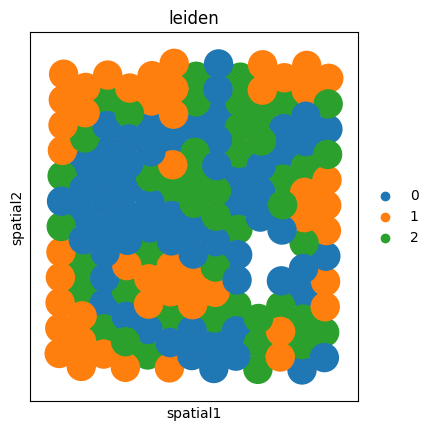

In [10]:
sc.tl.leiden(train_72_1, resolution=0.7, key_added="leiden")
sc.pl.spatial(train_72_1, color = 'leiden', size=1)

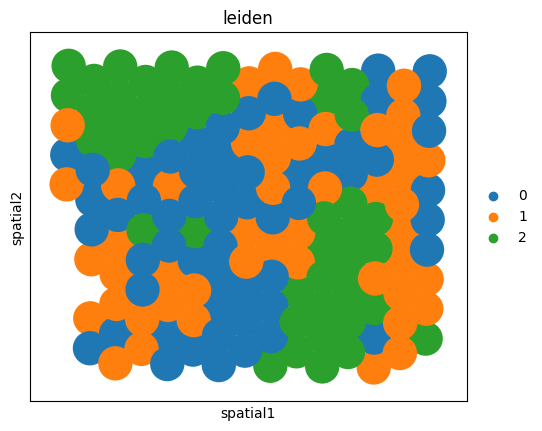

In [11]:
sc.tl.leiden(train_72_2, resolution=0.7, key_added="leiden")
sc.pl.spatial(train_72_2, color = 'leiden', size=1)

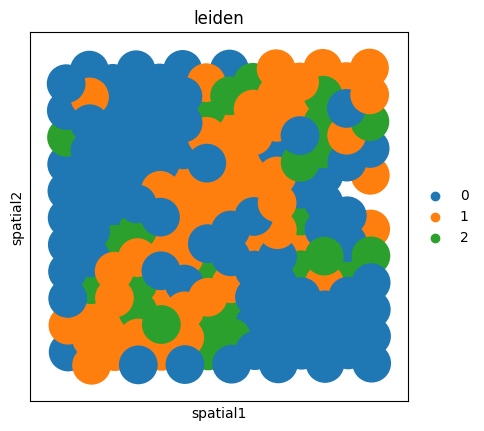

In [12]:
sc.tl.leiden(test_24_1, resolution=0.64, key_added="leiden")
sc.pl.spatial(test_24_1, color = 'leiden', size=5)

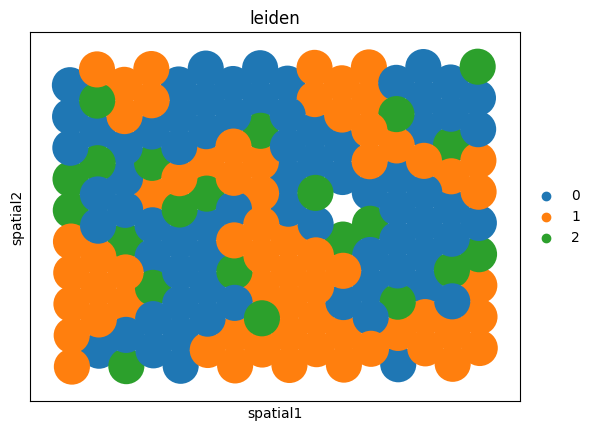

In [13]:
sc.tl.leiden(test_24_2, resolution=0.8, key_added="leiden")
sc.pl.spatial(test_24_2, color = 'leiden', size=4)

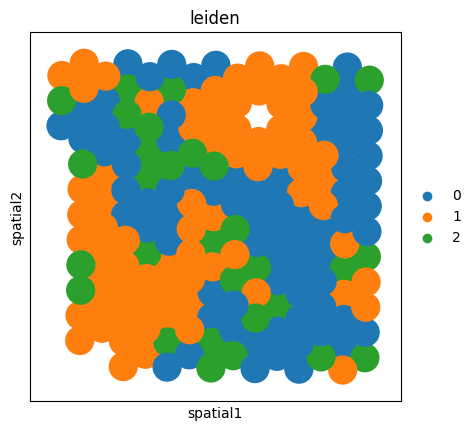

In [14]:
sc.tl.leiden(test_48_1, resolution=0.8, key_added="leiden")
sc.pl.spatial(test_48_1, color = 'leiden', size=1)

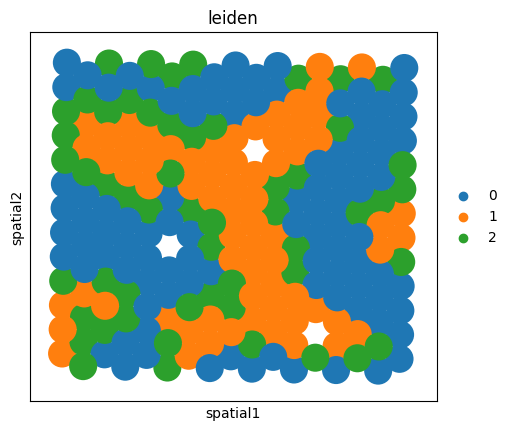

In [15]:
sc.tl.leiden(test_48_2, resolution=0.7, key_added="leiden")
sc.pl.spatial(test_48_2, color = 'leiden', size=1)